In [1]:
import sys
sys.path.insert(0, "../")

In [2]:
from fab.learnt_distributions.real_nvp import make_realnvp_dist_funcs
from fab.target_distributions.gmm import GMM
from fab.agent.fab_agent import AgentFAB
from fab.utils.plotting import plot_history, plot_marginal_pair, plot_contours_2D
import matplotlib.pyplot as plt
import optax
import jax
import jax.numpy as jnp

2022-04-03 21:10:55.072229: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [3]:
dim = 2
flow_num_layers = 10
mlp_hidden_size_per_x_dim = 5
layer_norm = False
act_norm = False
loc_scaling = 20

In [4]:
real_nvp_flo = make_realnvp_dist_funcs(dim, flow_num_layers,
                                       mlp_hidden_size_per_x_dim=mlp_hidden_size_per_x_dim,
                                      layer_norm=layer_norm, act_norm=act_norm)
target = GMM(dim, n_mixes=5, loc_scaling=loc_scaling, log_var_scaling=1.0, seed=1)
target_log_prob = target.log_prob
batch_size = 128
n_iter = int(1e4)
lr = 1e-4
max_grad_norm = 1.0
loss_type = "new"  # "forward_kl"  "alpha_2_div" "new"
style = "new"  # "vanilla"  "new"
use_reparam_loss = False
n_intermediate_distributions: int = 6
AIS_kwargs = {"additional_transition_operator_kwargs": {"step_tuning_method": "p_accept"}}
# optimizer = optax.chain(optax.zero_nans(), optax.clip_by_global_norm(max_grad_norm), optax.adamw(lr))
optimizer = optax.chain(optax.zero_nans(), optax.adam(lr))

In [5]:
bound = int(loc_scaling * 1.4)
def plotter(fab_agent, batch_size = 500):
    log_prob_2D = fab_agent.target_log_prob
    @jax.jit
    def get_info(state):
        base_log_prob = fab_agent.get_base_log_prob(state.learnt_distribution_params)
        target_log_prob = fab_agent.get_target_log_prob(state.learnt_distribution_params)
        x_base, log_q_x_base = fab_agent.learnt_distribution.sample_and_log_prob.apply(
            state.learnt_distribution_params, rng=state.key,
            sample_shape=(batch_size,))
        x_ais_loss, _, _, _ = \
            fab_agent.annealed_importance_sampler.run(
                x_base, log_q_x_base, state.key,
                state.transition_operator_state,
                base_log_prob=base_log_prob,
                target_log_prob=target_log_prob
            )
        x_ais_target, _, _, _ = \
            fab_agent.annealed_importance_sampler.run(
                x_base, log_q_x_base, state.key,
                state.transition_operator_state,
                base_log_prob=base_log_prob,
                target_log_prob=fab_agent.target_log_prob
            )
        return x_base, x_ais_loss, x_ais_target

    x_base, x_ais_loss, x_ais_target = get_info(fab_agent.state)
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    plot_contours_2D(log_prob_2D, ax=axs[0], bound=bound, levels=20)
    plot_marginal_pair(x_base, ax=axs[0], bounds=(-bound, bound))
    axs[0].set_title("base samples")
    plot_contours_2D(log_prob_2D, ax=axs[1], bound=bound, levels=bound)
    plot_marginal_pair(x_ais_loss, ax=axs[1], bounds=(-bound, bound))
    axs[1].set_title("p^2 / q samples")
    plot_contours_2D(log_prob_2D, ax=axs[2], bound=bound, levels=20)
    plot_marginal_pair(x_ais_target, ax=axs[2], bounds=(-bound, bound))
    axs[2].set_title("ais target samples")
    plt.show()
    return [fig]


In [6]:
fab_agent = AgentFAB(learnt_distribution=real_nvp_flo,
                     target_log_prob=target_log_prob,
                     n_intermediate_distributions=n_intermediate_distributions,
                     AIS_kwargs=AIS_kwargs,
                     optimizer=optimizer,
                     plotter=plotter,
                     loss_type=loss_type,
                     style=style,
                     add_reverse_kl_loss=use_reparam_loss
                )

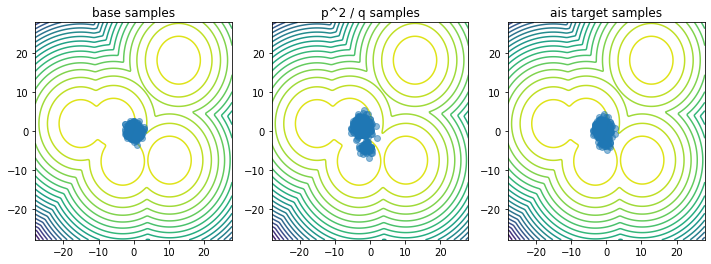

[<Figure size 864x288 with 3 Axes>]

In [7]:
plotter(fab_agent)

  0%|                                                                                                                                                                                                         | 0/10000 [00:00<?, ?it/s]

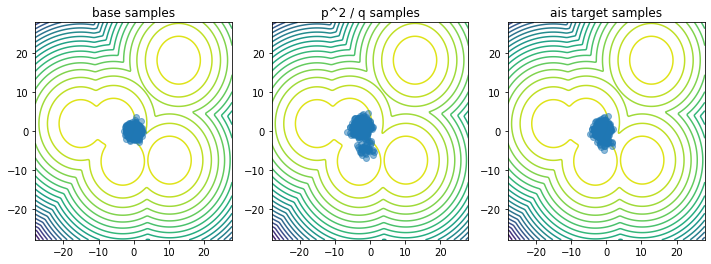

ess_ais: 0.02313537523150444, ess_base: 0.007937416434288025:  25%|███████████████████████████████▌                                                                                               | 2489/10000 [02:10<01:09, 108.39it/s]

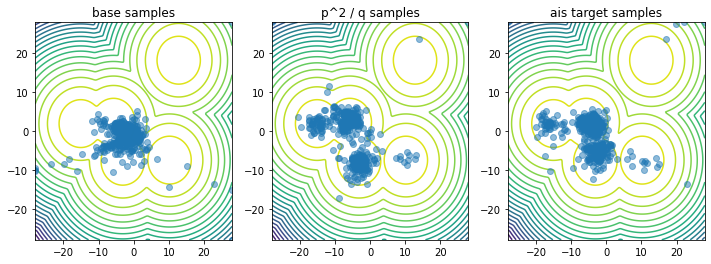

ess_ais: 0.12313557416200638, ess_base: 0.016815610229969025:  50%|███████████████████████████████████████████████████████████████▍                                                               | 4998/10000 [03:10<00:48, 103.60it/s]

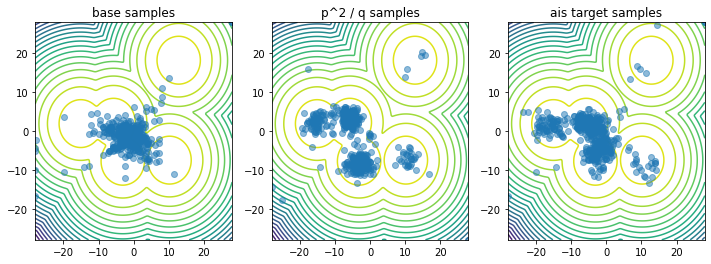

ess_ais: 0.020169906318187714, ess_base: 0.021726515144109726:  75%|██████████████████████████████████████████████████████████████████████████████████████████████▍                               | 7497/10000 [04:20<00:22, 111.55it/s]

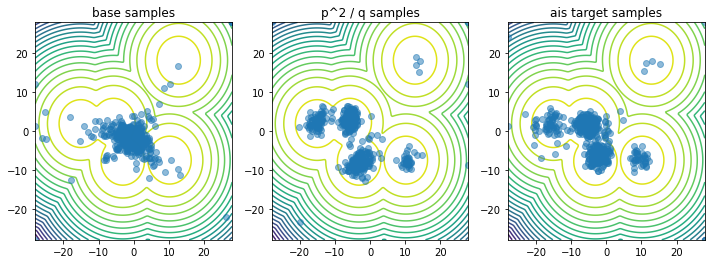

ess_ais: 0.0301181860268116, ess_base: 0.026845216751098633: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9991/10000 [05:20<00:00, 103.78it/s]

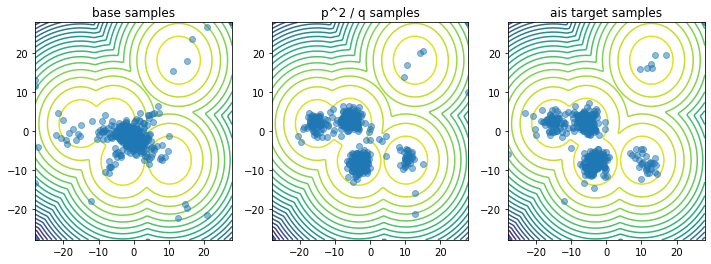

ess_ais: 0.0301181860268116, ess_base: 0.026845216751098633: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:50<00:00, 28.50it/s]


In [8]:
fab_agent.run(n_iter=n_iter, batch_size=batch_size, n_plots=5)

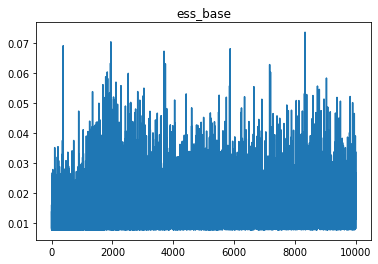

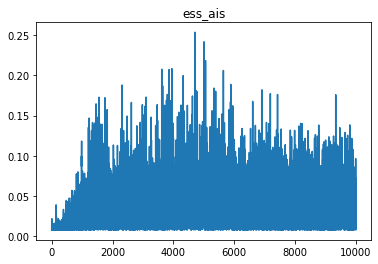

In [9]:
plt.plot(fab_agent.logger.history["ess_base"])
plt.title("ess_base")
plt.show()
plt.plot(fab_agent.logger.history["ess_ais"])
plt.title("ess_ais")
plt.show()
plt.show()

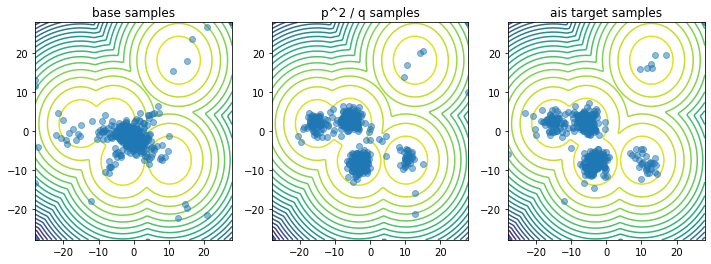

[<Figure size 864x288 with 3 Axes>]

In [10]:
plotter(fab_agent)